# 07. bonniema/salary-predictor

## Model 7: Use Job Title along with City, Rate Type and Cost of Living Indexes

## Import libraries and the final salary dataset

In [71]:
import time
from time import time
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
import string, re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Deep learning
import tensorflow as tf
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier #to use Keras in sklearn
from keras.initializers import Constant

# Deep Learning - Mixed inputs
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam, RMSprop

%matplotlib inline
np.random.seed(0)

[nltk_data] Downloading package stopwords to C:\Users\Doğan Yiğit
[nltk_data]     Yenigün\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
salary_df = pd.read_csv('salary_final_2.csv')

In [3]:
print(salary_df.shape)
# salary_df.drop('Unnamed: 0.2', axis=1, inplace=True)
salary_df.drop('Unnamed: 0.1', axis=1, inplace=True)
salary_df.drop('Unnamed: 0', axis=1, inplace=True)
salary_df.head()

(963, 27)


,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,low,high,...,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,City_Bins,combined_text,Salary_Bins
0,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,"Up to $215,000 a year",NaN,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,"2021048 Data Scientist $215,000.00 Position Re...",5
1,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,"$60,000 a year",NaN,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Data Science/Data Analyst Cost Readiness Analy...,1
2,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,$20,$25 an hour,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Data Science Intern Job Title: Data Science In...,0
3,Jr. Data Scientist,Numero Data LLC,https://www.indeed.com/company/Numero-Data-LLC...,None,"$70,000 - $85,000 a year",Ideal candidate should have a degree in a quan...,"Arlington, VA",Yearly,"$70,000","$85,000 a year",...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Jr. Data Scientist Ideal candidate should have...,2
4,Business Data Quality Engineer,HRU Technical Resources,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,$45 - $55 an hour,Please note that this is not a corp to corp or...,"Arlington, VA",Hourly,$45,$55 an hour,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Business Data Quality Engineer Please note tha...,3


In [4]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Title                           963 non-null    object 
 1   Company                         963 non-null    object 
 2   Link                            963 non-null    object 
 3   Review                          963 non-null    object 
 4   Salary                          963 non-null    object 
 5   Description                     963 non-null    object 
 6   Location2                       958 non-null    object 
 7   Rate_by                         963 non-null    object 
 8   low                             963 non-null    object 
 9   high                            762 non-null    object 
 10  min                             963 non-null    float64
 11  max                             963 non-null    float64
 12  adjusted_salary                 963 

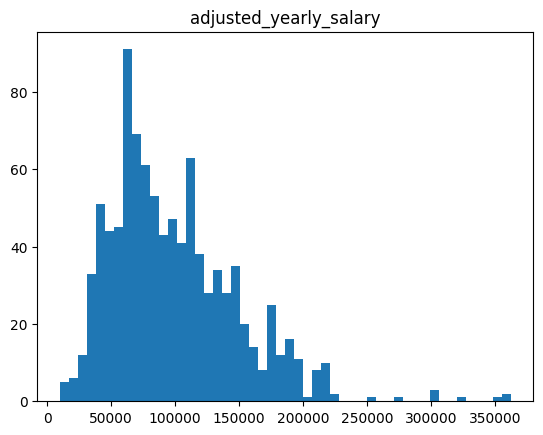

In [5]:
salary_df.hist('adjusted_yearly_salary', bins=50)
plt.grid(axis='both')
plt.show()

In [6]:
salary_df['adjusted_yearly_salary'].max() - salary_df['adjusted_yearly_salary'].min()

352500.0

In [7]:
salary_df['adjusted_yearly_salary'].quantile(list(np.linspace(0,1,7)))

0.000000     10000.000000
0.166667     54026.666667
0.333333     70000.000000
0.500000     90000.000000
0.666667    114400.000000
0.833333    145600.000000
1.000000    362500.000000
Name: adjusted_yearly_salary, dtype: float64

In [8]:
salary_df['Salary_Bins']

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: int64

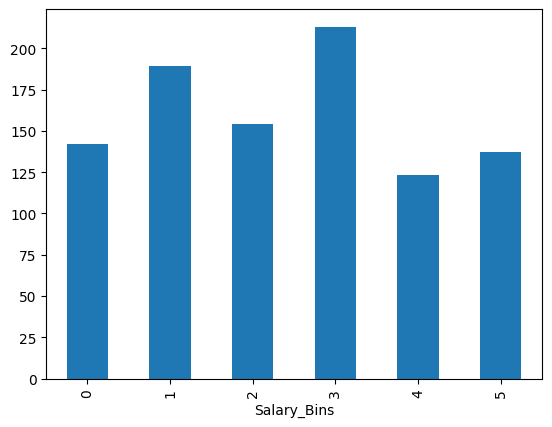

In [9]:
salary_df.groupby('Salary_Bins')['Location2'].count().plot.bar()
plt.show()

In [10]:
# Categorical target
target_class = salary_df['Salary_Bins'].astype('category')
target_class

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [11]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['www','http','com','llc','covid','non','pm','am','eg','e','g','ie','i']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)

    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [12]:
data = clean_word(salary_df['combined_text'])
data

0      [data, scientist, position, requires, top, sec...
1      [data, science, data, analyst, cost, readiness...
2      [data, science, intern, job, title, data, scie...
3      [jr, data, scientist, ideal, candidate, degree...
4      [business, data, quality, engineer, please, no...
                             ...                        
958    [data, engineering, ii, data, engineering, ii,...
959    [ir, day, shift, tier, ir, day, shift, salary,...
960    [security, engineer, security, engineer, salar...
961    [fdp, analyst, position, title, fdp, analyst, ...
962    [junior, ms, access, vba, developer, want, acc...
Length: 963, dtype: object

## Model 7: Use Job Title along with City, Rate Type and Cost of Living Indexes

Previously, model 1-5 uses job description and job title as the combined text in the text classification model. However, due to large number of words in one job description, using the whole text may not be the best way to extract information because many unrelevant words can show up, even with TF-IDF.

Now, in this last model, 'Title' will be used as a separate set of feature to predict salary.

In [13]:
salary_df['Title']

0      2021048 Data Scientist $215,000.00
1               Data Science/Data Analyst
2                     Data Science Intern
3                      Jr. Data Scientist
4          Business Data Quality Engineer
                      ...                
958                   Data Engineering II
959                          IR Day Shift
960                     Security Engineer
961                           FDP Analyst
962       Junior MS Access/ VBA Developer
Name: Title, Length: 963, dtype: object

In [16]:
salary_df['City_Bins'].unique()

array(['medium', 'low', nan, 'high'], dtype=object)

In [17]:
# Drop rows with NA values of City_Bins
salary_df_new = salary_df.dropna(axis = 0, subset = ['City_Bins'])

In [18]:
salary_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 939 entries, 0 to 962
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Title                           939 non-null    object 
 1   Company                         939 non-null    object 
 2   Link                            939 non-null    object 
 3   Review                          939 non-null    object 
 4   Salary                          939 non-null    object 
 5   Description                     939 non-null    object 
 6   Location2                       939 non-null    object 
 7   Rate_by                         939 non-null    object 
 8   low                             939 non-null    object 
 9   high                            743 non-null    object 
 10  min                             939 non-null    float64
 11  max                             939 non-null    float64
 12  adjusted_salary                 939 

In [22]:
salary_df_new.loc[0:40,'Title']

0                    2021048 Data Scientist $215,000.00
1                             Data Science/Data Analyst
2                                   Data Science Intern
3                                    Jr. Data Scientist
4                        Business Data Quality Engineer
5                                        Data Scientist
6     Machine Learning / C++ Engineer (DoD Clearance...
7     Undergraduate Internship/Co-op Program - Data ...
8                           Data Science Community Lead
9                           Data Analyst/Data Scientist
10    Self-employed Hardware/ Data Centre Field Engi...
11                       DATA SCIENCE & TAGGING ANALYST
12                                        Data Engineer
13                                       Data Scientist
14                                       Data Scientist
15    HPC / Computational Data Scientist with Clearance
16         Operations Research Analyst (Data Scientist)
17                               Social Science 

In [23]:
salary_df_new = salary_df_new.reset_index(drop=True)

In [25]:
print(salary_df_new.shape)
salary_df_new.head()

(939, 25)


,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,low,high,...,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,City_Bins,combined_text,Salary_Bins
0,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,"Up to $215,000 a year",NaN,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,"2021048 Data Scientist $215,000.00 Position Re...",5
1,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,"$60,000 a year",NaN,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Data Science/Data Analyst Cost Readiness Analy...,1
2,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,$20,$25 an hour,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Data Science Intern Job Title: Data Science In...,0
3,Jr. Data Scientist,Numero Data LLC,https://www.indeed.com/company/Numero-Data-LLC...,None,"$70,000 - $85,000 a year",Ideal candidate should have a degree in a quan...,"Arlington, VA",Yearly,"$70,000","$85,000 a year",...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Jr. Data Scientist Ideal candidate should have...,2
4,Business Data Quality Engineer,HRU Technical Resources,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,$45 - $55 an hour,Please note that this is not a corp to corp or...,"Arlington, VA",Hourly,$45,$55 an hour,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Business Data Quality Engineer Please note tha...,3


In [26]:
job_title = salary_df_new['Title']

In [27]:
# Use count vectorizer to examine title
cv = CountVectorizer(stop_words='english', ngram_range=(1,3), max_df=0.3, min_df=0.03)

In [29]:
# Fit count vectorizer to job title
cv.fit(job_title)
title_words = pd.DataFrame(cv.transform(job_title).todense(), columns=cv.get_feature_names_out())

In [30]:
title_words.describe()

,analyst,analytics,business,business analyst,data,data analyst,data engineer,data scientist,digital,director,...,marketing,sales,science,scientist,senior,senior data,software,software engineer,specialist,systems
count,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,...,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000
mean,0.299255,0.033014,0.153355,0.103301,0.310969,0.057508,0.085197,0.071353,0.036209,0.040469,...,0.083067,0.040469,0.033014,0.074547,0.123536,0.034079,0.044728,0.031949,0.033014,0.033014
std,0.474184,0.178768,0.360521,0.304514,0.509187,0.232935,0.290548,0.257550,0.186909,0.207694,...,0.276131,0.197161,0.178768,0.262800,0.329226,0.181528,0.216882,0.175958,0.178768,0.178768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000


In [32]:
# One-hot encoding of categorical feature City_Bins
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
salary_df_new['City_cat'] = labelencoder.fit_transform(salary_df_new['City_Bins'])

In [33]:
salary_df_new['City_cat']

0      2
1      2
2      2
3      2
4      2
      ..
934    0
935    0
936    0
937    0
938    0
Name: City_cat, Length: 939, dtype: int32

In [34]:
# Construct model dataset
X = pd.concat([title_words, salary_df_new['City_cat'], salary_df_new['Cost of Living Plus Rent Index']], axis=1)
y = salary_df_new['Salary_Bins'].astype('category')

In [35]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)

In [40]:
# Add City Bins and Local Purchase Power Index
word_observe = pd.concat([title_words, y], axis=1)
word_observe.head(10)

,analyst,analytics,business,business analyst,data,data analyst,data engineer,data scientist,digital,director,...,sales,science,scientist,senior,senior data,software,software engineer,specialist,systems,Salary_Bins
0,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,5
1,1,0,0,0,2,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,2
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
5,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,4
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
7,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
8,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,1,0,0,0,2,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,3


In [38]:
table = pd.pivot_table(word_observe, index=['Salary_Bins'])
table

,analyst,analytics,business,business analyst,data,data analyst,data engineer,data scientist,digital,director,...,marketing,sales,science,scientist,senior,senior data,software,software engineer,specialist,systems
Salary_Bins,,,,,,,,,,,,,,,,,,,,,
0,0.164179,0.000000,0.037313,0.022388,0.141791,0.029851,0.000000,0.022388,0.067164,0.007463,...,0.208955,0.029851,0.044776,0.022388,0.022388,0.007463,0.007463,0.000000,0.067164,0.007463
1,0.400000,0.010811,0.189189,0.162162,0.172973,0.059459,0.010811,0.059459,0.027027,0.027027,...,0.102703,0.043243,0.021622,0.064865,0.037838,0.005405,0.005405,0.000000,0.070270,0.000000
2,0.500000,0.033333,0.206667,0.140000,0.293333,0.140000,0.033333,0.053333,0.086667,0.026667,...,0.093333,0.066667,0.000000,0.053333,0.086667,0.026667,0.000000,0.000000,0.033333,0.046667
3,0.347619,0.061905,0.204762,0.119048,0.423810,0.061905,0.138095,0.076190,0.033333,0.038095,...,0.033333,0.019048,0.042857,0.076190,0.166667,0.042857,0.047619,0.014286,0.009524,0.076190
4,0.178862,0.040650,0.154472,0.097561,0.414634,0.016260,0.178862,0.105691,0.000000,0.048780,...,0.065041,0.048780,0.032520,0.113821,0.162602,0.024390,0.048780,0.040650,0.016260,0.032520
5,0.109489,0.043796,0.080292,0.043796,0.416058,0.021898,0.160584,0.116788,0.000000,0.102190,...,0.014599,0.043796,0.058394,0.124088,0.277372,0.102190,0.175182,0.160584,0.000000,0.021898


**From the distribution above, we can tell some words appear more for higher salary bin than the others.**

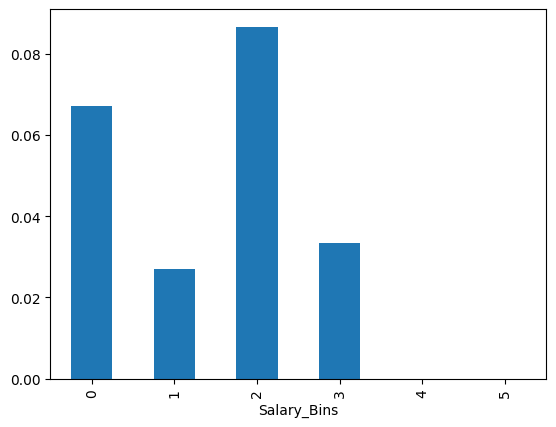

In [42]:
# Word 'digital' mostly appear in lower bins
table['digital'].plot.bar()
plt.show()

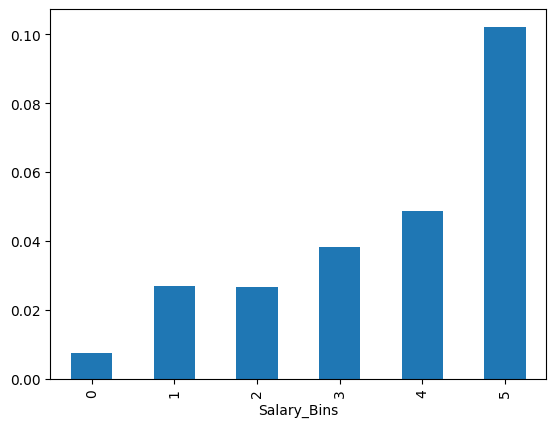

In [44]:
# Word 'director' mostly appear in higher bins
table['director'].plot.bar()
plt.show()

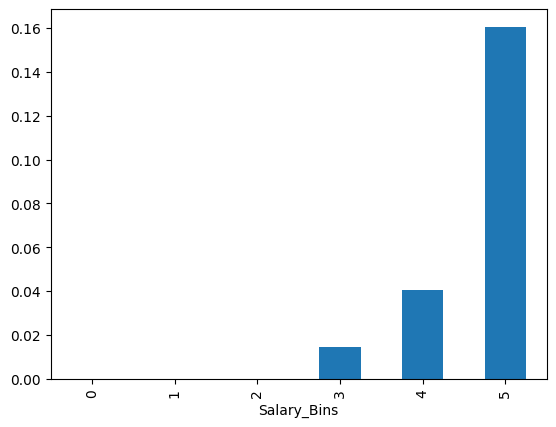

In [46]:
# Word 'software engineer' mostly appear in higher bins
table['software engineer'].plot.bar()
plt.show()

How can we use the frequency as features in the model?

In [48]:
# Take a look at the word frequencies for each bin below
for i in range(0,6):
    word_count = word_observe[word_observe['Salary_Bins'] == i].sum(axis=0)
    print("Bin {} >> Most common words:".format(i))
    cw = word_count.sort_values(ascending=False).head(20)
    print(cw)

Bin 0 >> Most common words:
marketing           28
analyst             22
data                19
manager             15
specialist           9
digital              9
science              6
business             5
data analyst         4
engineer             4
sales                4
business analyst     3
data scientist       3
senior               3
scientist            3
machine              2
machine learning     1
learning             1
director             1
senior data          1
dtype: int64
Bin 1 >> Most common words:
analyst             74
business            35
data                32
business analyst    30
manager             20
marketing           19
specialist          13
scientist           12
data analyst        11
data scientist      11
sales                8
engineer             8
senior               7
director             5
digital              5
science              4
analytics            2
data engineer        2
software             1
senior data          1
dtype: int6

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Temp\ipykernel_14672\3948255415.py:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  word_count = word_observe[word_observe['Salary_Bins'] == i].sum(axis=0)


### Random Forest as Base Model

In [66]:
# Inititate Random Forest classifier
rf = RandomForestClassifier()
parameters = {
    'criterion': ("gini","entropy"),
    'min_samples_split': (2,6,8),
    'max_features': ("sqrt","log2"),
    'max_samples': (None, 0.5,0.8,1) 
}

clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)
print("Best parameter CV score = %0.3f" % clf.best_score_)
print("Best parameters:", clf.best_params_)

Best parameter CV score = 0.392
Best parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_samples': 0.8, 'min_samples_split': 2}


In [60]:
clf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.5,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [61]:
clf.score(X_test, y_test)

0.39361702127659576

In [62]:
# Check feature importance of the best performing model
rf = RandomForestClassifier(criterion='gini', max_samples=0.8)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

In [63]:
importances

array([0.04533156, 0.0256805 , 0.02669656, 0.01126054, 0.05144918,
       0.01211166, 0.01965831, 0.01015813, 0.02058548, 0.02708727,
       0.03962206, 0.00589787, 0.00706904, 0.00637685, 0.03412069,
       0.03644123, 0.0326447 , 0.01672652, 0.01269364, 0.0447654 ,
       0.01187726, 0.02229568, 0.01175048, 0.0180727 , 0.01939655,
       0.0732503 , 0.35697984])

In [64]:
X_train.head()

,analyst,analytics,business,business analyst,data,data analyst,data engineer,data scientist,digital,director,...,science,scientist,senior,senior data,software,software engineer,specialist,systems,City_cat,Cost of Living Plus Rent Index
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,74.800000
379,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,59.399889
67,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,60.940000
672,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2,64.660000
337,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,63.110000


### PCA & Random Forest in the Pipeline

In [65]:
from sklearn.decomposition import PCA
pca = PCA()
rf = RandomForestClassifier(criterion='gini', max_samples=0.8)
pipe = Pipeline(steps=[('pca', pca), ('rf', rf)])

param  = {
    'pca__n_components': [3,5,10,15,20,25],
    'rf__criterion': ("gini","entropy"),
    'rf__min_samples_split': (2,6,8),
}

search = GridSearchCV(pipe, param, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter CV score = %0.3f" % search.best_score_)
print(search.best_params_)

Best parameter CV score = 0.393
{'pca__n_components': 20, 'rf__criterion': 'entropy', 'rf__min_samples_split': 2}


### XGBoost

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
pca = PCA()
XGB = GradientBoostingClassifier(random_state=4)
pipe = Pipeline(steps=[('pca', pca), ('xgb', XGB)])

param  = {
    'pca__n_components':[3,5,10,15,20,25],
    'xgb__loss':("log_loss","exponential"),
    'xgb__learning_rate':(0.1, 0.01, 0.001),
    'xgb__subsample':(0.3,0.5,1.0),
}

search = GridSearchCV(pipe, param, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter CV score = %0.3f" % search.best_score_)
print("Best parameters:", search.best_params_)

Best parameter CV score = 0.389
Best parameters: {'pca__n_components': 25, 'xgb__learning_rate': 0.1, 'xgb__loss': 'log_loss', 'xgb__subsample': 0.5}


# CONCLUSION

### Let's recap the individual scores we obtained from all the 7 models:

**Model 1 - Word2Vec Embedding in Classification Models:** 

Random Forest Fit-Predict: 0.546391 | Random Forest with Grid Search: 0.472 | SGD with Grid Search: 0.381

**Model 2 - CountVectorizer + TF-IDF Transformation in Classification Models:**

SGD with Grid Search: 0.549 | SGD Fit-Predict: 0.721649 | Random Forest with Grid Search: 0.550 | Random Forest Fit-Predict: 0.598

**Model 3 - Pre-Trained GloVe Model in Classification Models:**

Random Forest with Grid Search: 0.472 | Random Forest Fit-Predict: 0.525773 | SGD Fit-Predict: 0.3298

**Model 4 - Deep Learning Models with Word Embeddings (Train/Test):**

1st Model: 0.3662/0.2435 | 2nd Model: 0.4607/0.3093 | 3rd Model: 0.9503/0.4536

**Model 5 - Pre-Trained Word2Vec as the Embedding Layer in Deep Learning Models (Train/Test):**

1st Model: 0.9988/0.4639 | 2nd Model: 1.0000/0.3814 | Similar 2nd Model Grid Search: 0.431881 | 3rd Model: 0.8221/0.5285 | Similar 3rd Model Grid Search: 0.442794

**Model 6 - Mixed Input Model with City, Rate Type and Cost of Living Indexes (Train/Test):**

1st Model: 0.8730/0.4845 | 2nd Model: 0.8349/0.5155

**Model 7 - Use Job Title along with City, Rate Type and Cost of Living Indexes:**

Random Forest Grid Search: 0.392 | Random Forest Fit-Predict: 0.393617 | PCA & Random Forest Grid Search: 0.393 | XGBoost Grid Search: 0.389

### **Among all these obtained scores, we can confirm that Model 2 is the best model for salary prediction!**